# Intro

In this example, we'll use a combination of Jupyter notebooks, Pandas, and Pachyderm to analyze Citi Bike sales data.

In [1]:
%matplotlib inline

import os
import datetime
from io import StringIO

import pandas as pd
import python_pachyderm

# Insert Data

First, we'll create a couple of repos and populate them:

- **trips** - This repo is populated with a daily file that records the number of bicycle trips recorded by NYC's citibike bike sharing company on that particular day (data from [here](https://www.citibikenyc.com/system-data)).
- **weather** - This repo is populated daily with a JSON file representing the weather forecast for that day from [forecast.io](https://darksky.net/forecast/40.7127,-74.0059/us12/en).

In [2]:
client = python_pachyderm.Client()

# First create the repos/pipelines
client.create_repo("trips")
client.create_repo("weather")
client.create_pipeline(
    "jupyter",
    transform=python_pachyderm.Transform(
        image="pachyderm/pachyderm_jupyter:2019",
        cmd=["python3", "merge.py"],
    ),
    input=python_pachyderm.Input(cross=[
        python_pachyderm.Input(pfs=python_pachyderm.PFSInput(glob="/", repo="weather")),
        python_pachyderm.Input(pfs=python_pachyderm.PFSInput(glob="/", repo="trips")),
    ])
)

In [3]:
# Populate the input repos
def insert_data(name):
    print("Inserting {} data...".format(name))
    with client.commit(name, "master") as c:
        data_dir = "{}_data".format(name)

        for data_filename in os.listdir(data_dir):
            data_filepath = os.path.join(data_dir, data_filename)
            with open(data_filepath, "rb") as f:
                client.put_file_bytes(c, data_filename, f)
                
        return c
            
trips_commit = insert_data("trips")
weather_commit = insert_data("weather")

# Wait for the commits to finish
print("Waiting for commits to finish...")
for commit in client.flush_commit([trips_commit, weather_commit]):
    print(commit)

Inserting trips data...
Inserting weather data...
Waiting for commits to finish...
commit {
  repo {
    name: "jupyter"
  }
  id: "e0094ec051e74634a56f0a438a66a9fd"
}
parent_commit {
  repo {
    name: "jupyter"
  }
  id: "8a5ad4469b0c4ee7b0b6acdb38078199"
}
started {
  seconds: 1568998174
  nanos: 196552100
}
finished {
  seconds: 1568998186
  nanos: 511221200
}
size_bytes: 2586
trees {
  hash: "8757c9af88cc991df3cbb3512ae8ed489b4ebe785949207f8163ea807a79bf478e445c85951c4f3fdd6a0d2361daf5eb0aaf7aa944702a4d55e05a2d95acf2ef"
}
datums {
  hash: "baf62b1b4e57108d944ecaedeb51fba7a16b83fd9a89a75b9dad680ce73fee265a5a09b398205570fb35ca3fd7188ebaa7eee183b41365c32a4bcb5736eeca2c"
}
branch {
  repo {
    name: "jupyter"
  }
  name: "master"
}
provenance {
  commit {
    repo {
      name: "__spec__"
    }
    id: "9f8581ff563948de99d6ec62c78952b0"
  }
  branch {
    repo {
      name: "__spec__"
    }
    name: "jupyter"
  }
}
provenance {
  commit {
    repo {
      name: "trips"
    }
    id:

In [4]:
file = client.get_file(("jupyter", "master"), "data.csv")
contents = "\n".join([chunk.decode("utf8") for chunk in file])
df = pd.read_csv(StringIO(contents), names=["Date", "Precipitation", "Trips", "Sales"], index_col="Date")
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# Get just July 2016
df = df[datetime.datetime(year=2016, month=7, day=1):datetime.datetime(year=2016, month=7, day=31)]
print(df)

            Precipitation  Trips   Sales
Date                                    
2016-07-01           0.83  39665  198325
2016-07-02           0.00  35835  179175
2016-07-03           0.00  35347  176735
2016-07-04           0.59  34859  174295
2016-07-05           0.89  43736  218680
2016-07-06           0.00  51336  256680
2016-07-07           0.68  48724  243620
2016-07-08           0.52  44400  222000
2016-07-09           0.82  38138  190690
2016-07-10           0.84  41985  209925
2016-07-11           0.00  52853  264265
2016-07-12           0.00  56515  282575
2016-07-13           0.00  55471  277355
2016-07-14           0.91  50345  251725
2016-07-15           0.00  48558  242790
2016-07-16           0.20  38405  192025
2016-07-17           0.00  41346  206730
2016-07-18           0.85  43681  218405
2016-07-19           0.00  54587  272935
2016-07-20           0.00  57213  286065
2016-07-21           0.00  54832  274160
2016-07-22           0.00  49185  245925
2016-07-23      

# Visualize the sales in the context of weather

Finally, we confirm our suspicions by visualizing the precipitation probabilities with the sales data:

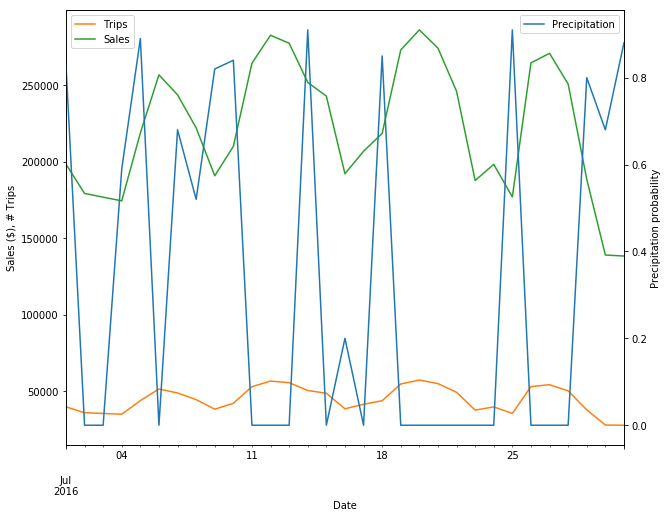

In [5]:
ax = df.plot(secondary_y=["Precipitation"], figsize=(10, 8))
ax.set_ylabel("Sales ($), # Trips")
ax.right_ax.set_ylabel("Precipitation probability")
ax.right_ax.legend(loc="best")
ax.legend(loc="upper left")

We can see that their was a probability of precipitation in NYC above 70% both of the days in question.  This is likely to be the explanation for the poor sales. Of course, we can attach our Jupyter notebook other parts of the data to explore other unexpected behavior, develop further analyses, etc.